In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import skbio
from skbio.stats.distance import bioenv
from skbio.stats.distance import permanova
from skbio.stats.distance import anosim
from skbio.stats.distance import DistanceMatrix
from matplotlib import rcParams as rcParams
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib import rc as rc
import matplotlib.gridspec as gridspec
# from skbio.stats.composition import ancom
# from skbio.stats.distance import distancematrix
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn import decomposition
from sklearn.preprocessing import scale
import matplotlib.gridspec as gridspec
from skbio.stats.distance import mantel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [4]:
map_df = pd.read_csv('../QIIME2/mapping_file/mapping_file.txt', index_col = 0, sep = '\t')
map_df.head()

,genotype_1,fertility_1,amf,rep_1,group_1,shoot_mass,root_mass,total_mass,ratio_root _to_shoot,root_colonization,...,Mn,G_5,FERT_5,AMF,REP_5,group_5,Length(cm),AvgDiam(mm),Forks,SurfArea(cm2)
#SampleID,,,,,,,,,,,,,,,,,,,,,
L1,1,P,Y,1,Common (C. dactylon),29.961,4.46,34.421,0.129572,43.0,...,134.694,1,P,Y,1,Common (C. dactylon),162.8464,0.2905,904.0,14.8643
L10,1,PPP,Y,2,Common (C. dactylon),26.283,10.16,36.443,0.278792,36.0,...,66.900,1,PPP,Y,2,Common (C. dactylon),329.7942,0.2978,2620.0,30.8595
L100,9,PP,Y,5,Common (C. dactylon),18.142,6.82,24.962,0.273215,21.0,...,55.564,9,PP,Y,5,Common (C. dactylon),229.4975,0.3495,1577.0,25.1969
L101,9,PP,Y,1,Common (C. dactylon),25.649,10.88,36.529,0.297846,26.0,...,70.900,9,PP,Y,1,Common (C. dactylon),216.1839,0.3708,1395.0,25.1835
L102,9,PP,Y,2,Common (C. dactylon),25.664,12.66,38.324,0.330341,39.0,...,83.900,9,PP,Y,2,Common (C. dactylon),302.0509,0.2743,1827.0,26.0297


In [3]:
map_df.columns.values

array(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M',
       'x', 'y', 'date', 'year', 'year_landform', 'precip_1month',
       'precip_2month', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'Missing16S', 'MissingITS', 'BD (g/cm3)', '% total C',
       '% Minerals', '% OM', '% Org C', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay', 'BG_nmol/g/hr',
       'CBH_nmol/g/hr', 'PHOS_nmol/g/hr', 'NAG_nmol/g/hr', 'BX_nmol/g/hr',
       'AG_nmol/g/hr', 'LAP_nmol/g/hr', 'BG_umol/cm^2 stone-free',
       'CBH_umol/cm^2 stone-free', 'PHOS_umol/cm^2 stone-free',
       'NAG_umol/cm^2 stone-free', 'BX_umol/cm^2 stone-free',
       'AG_umol/cm^2 stone-free', 'LAP_umol/cm^2 stone-free',
 

In [4]:
# Get Lindas help with justification for removing sample
# removed ,'LAP_umol/cm^2 SF C'
features = ['BG_umol/cm^2 SF C',
       'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C',
       'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
map_df_na = map_df[features].dropna()
# Separating out the features
x = map_df_na.loc[:, features].values
# Separating out the target
# y = map_df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, index = map_df_na.index
             , columns = ['PCA 1', 'PCA 2'])
map_df = pd.concat([map_df, principalDf], axis = 1)

In [5]:
pca.explained_variance_ratio_

array([0.81893601, 0.10178111])

In [6]:
# dm_df_bc_16s = pd.read_csv('../Bioinformatics/16S/core-metrics-results/exported-bray-curtis/distance-matrix.tsv', sep='\t', index_col=0).sort_index()
dm_df_bc_16s = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/exported-bray-curtis/16S-distance-matrix.tsv', sep='\t', index_col=0).sort_index()
dm_df_bc_its = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/exported-bray-curtis/ITS-distance-matrix.tsv', sep='\t', index_col=0).sort_index()
# print(map_df.index.isin(dm_df_bc_16s.index))
map_df_16s = map_df[map_df.index.isin(dm_df_bc_16s.index)]
map_df_its = map_df[map_df.index.isin(dm_df_bc_its.index)]
print(len(dm_df_bc_16s.index))
print(len(map_df.index))
dm_df_bc_16s = dm_df_bc_16s.filter(map_df.index, axis = 1).filter(map_df.index, axis = 0)
dm_df_bc_its = dm_df_bc_its.filter(map_df.index, axis = 1).filter(map_df.index, axis = 0)
print(len(dm_df_bc_16s.index))
print(map_df_16s.index.values)
print(dm_df_bc_16s.index.values)

dm_df_bc_16s = DistanceMatrix(dm_df_bc_16s, ids=dm_df_bc_16s.index)
dm_df_bc_its = DistanceMatrix(dm_df_bc_its, ids=dm_df_bc_its.index)

print(dm_df_bc_16s.shape)

36
38
36
['M-SS2-11' 'M-SS2-30' 'M-SS2-80' 'M-SS3-120' 'M-SS3-150' 'M-SS3-20'
 'M-SS3-200' 'M-SS3-46' 'M-SS3-7' 'M-SS4-125' 'M-SS4-23' 'M-SS4-65'
 'M-SS4-8' 'M-SS4-90' 'M-SS5-100' 'M-SS5-22' 'M-SS5-63' 'M-SS5-9'
 'PG-PG1-19' 'PG-PG1-36' 'PG-PG1-6' 'PG-PG1-60' 'PG-PG1-80' 'PG-PG2-100'
 'PG-PG2-11' 'PG-PG2-25' 'PG-PG2-35' 'PG-PG2-65' 'PG-PG3-15' 'PG-PG3-48'
 'PG-PG3-65' 'PG-PG3-8' 'PG-SS1-17' 'PG-SS1-39' 'PG-SS1-5' 'PG-SS1-90']
['M-SS2-11' 'M-SS2-30' 'M-SS2-80' 'M-SS3-120' 'M-SS3-150' 'M-SS3-20'
 'M-SS3-200' 'M-SS3-46' 'M-SS3-7' 'M-SS4-125' 'M-SS4-23' 'M-SS4-65'
 'M-SS4-8' 'M-SS4-90' 'M-SS5-100' 'M-SS5-22' 'M-SS5-63' 'M-SS5-9'
 'PG-PG1-19' 'PG-PG1-36' 'PG-PG1-6' 'PG-PG1-60' 'PG-PG1-80' 'PG-PG2-100'
 'PG-PG2-11' 'PG-PG2-25' 'PG-PG2-35' 'PG-PG2-65' 'PG-PG3-15' 'PG-PG3-48'
 'PG-PG3-65' 'PG-PG3-8' 'PG-SS1-17' 'PG-SS1-39' 'PG-SS1-5' 'PG-SS1-90']
(36, 36)


In [7]:
mutual = list(set(dm_df_bc_16s.ids).intersection(dm_df_bc_its.ids))
print(mutual)
dm_df_bc_its_filtered = dm_df_bc_its.filter(mutual)
print(len(dm_df_bc_its.ids))
print(len(dm_df_bc_its_filtered.ids))
dm_df_bc_16s_filtered = dm_df_bc_16s.filter(mutual)
print(len(dm_df_bc_16s.ids))
print(len(dm_df_bc_16s_filtered.ids))

['PG-PG2-65', 'M-SS3-46', 'PG-PG3-8', 'PG-PG1-36', 'M-SS2-11', 'M-SS3-150', 'M-SS4-23', 'M-SS5-9', 'PG-PG2-100', 'PG-SS1-5', 'M-SS2-80', 'M-SS4-90', 'M-SS2-30', 'PG-SS1-90', 'PG-SS1-39', 'M-SS3-20', 'M-SS3-200', 'PG-SS1-17', 'PG-PG1-60', 'M-SS4-8', 'PG-PG1-6', 'PG-PG3-15', 'M-SS3-7', 'PG-PG3-65', 'M-SS3-120', 'PG-PG2-35', 'M-SS4-65', 'M-SS5-63', 'PG-PG1-80', 'PG-PG3-48', 'PG-PG1-19', 'PG-PG2-25', 'M-SS5-100']
35
33
36
33


In [8]:
coeff, p_value, n = mantel(dm_df_bc_16s_filtered, dm_df_bc_its_filtered, method = 'spearman')
print(coeff)
print(p_value)

0.3471469803822758
0.001


In [9]:
its_ids = list(set(dm_df_bc_its.ids) & set(map_df[map_df['Depth(cm)'] <= 30].index.values))
dm_df_bc_its_30 = dm_df_bc_its.filter(its_ids)
print(len(dm_df_bc_its_30.ids))
s16_ids = list(set(dm_df_bc_16s.ids) & set(map_df[map_df['Depth(cm)'] <= 30].index.values))
dm_df_bc_16s_30 = dm_df_bc_16s.filter(s16_ids)
print(len(dm_df_bc_16s_30.ids))

its_ids = list(set(dm_df_bc_its.ids) & set(map_df[map_df['Depth(cm)'] > 30].index.values))
dm_df_bc_its_b30 = dm_df_bc_its.filter(its_ids)
print(len(dm_df_bc_its_b30.ids))
s16_ids = list(set(dm_df_bc_16s.ids) & set(map_df[map_df['Depth(cm)'] > 30].index.values))
dm_df_bc_16s_b30 = dm_df_bc_16s.filter(s16_ids)
print(len(dm_df_bc_16s_b30.ids))
# dm_df_bc_16s_filtered_30 = dm_df_bc_16s.filter(mutual_30)
# print(len(dm_df_bc_16s_filtered_30.ids))
# mutual_b30 = list(set(mutual).intersection(map_df[map_df['Depth(cm)'] > 30].index.values))
# dm_df_bc_its_filtered_b30 = dm_df_bc_its.filter(mutual_b30)
# print(len(dm_df_bc_its_filtered_b30.ids))
# dm_df_bc_16s_filtered_b30 = dm_df_bc_16s.filter(mutual_b30)
# print(len(dm_df_bc_16s_filtered_b30.ids))

14
16
21
20


In [10]:
# coeff, p_value, n = mantel(dm_df_bc_16s_30, dm_df_bc_its_30, method = 'spearman')
# print(coeff)
# print(p_value)

In [11]:
def distance_on_sphere_numpy(coordinate_array):
    """
    Compute a distance matrix of the coordinates using a spherical metric.
    :param coordinate_array: numpy.ndarray with shape (n,2); latitude is in 1st col, longitude in 2nd.
    :returns distance_mat: numpy.ndarray with shape (n, n) containing distance in km between coords.
    """
    # Radius of the earth in km (GRS 80-Ellipsoid)
    EARTH_RADIUS = 6371.007176 

    # Unpacking coordinates
    latitudes = coordinate_array[:, 0]
    longitudes = coordinate_array[:, 1]

    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0
    phi_values = (90.0 - latitudes)*degrees_to_radians
    theta_values = longitudes*degrees_to_radians

    # Expand phi_values and theta_values into grids
    theta_1, theta_2 = np.meshgrid(theta_values, theta_values)
    theta_diff_mat = theta_1 - theta_2

    phi_1, phi_2 = np.meshgrid(phi_values, phi_values)

    # Compute spherical distance from spherical coordinates
    angle = (np.sin(phi_1) * np.sin(phi_2) * np.cos(theta_diff_mat) + 
           np.cos(phi_1) * np.cos(phi_2))
    arc = np.arccos(angle)

    # Multiply by earth's radius to obtain distance in km
    return arc * EARTH_RADIUS

In [12]:
geo_dist = pd.DataFrame(distance_on_sphere_numpy(map_df[['x','y']].values))
geo_dist.index = map_df.index
geo_dist.columns = map_df.index
geo_dist[geo_dist < 0.001] = 0
# geo_dist.to_csv('../Data/geographic_distance.csv')
geo_dist_dm = DistanceMatrix(geo_dist, ids = map_df.index)

In [13]:
def compute_mantel(x,y):
    mutual = list(set(x.ids).intersection(y.ids))
    x = x.filter(mutual)
    y = y.filter(mutual)
    coeff, p_value, n = mantel(x, y, method = 'spearman')
    return(coeff,p_value)

In [14]:
print('16S vs geo')
print(compute_mantel(dm_df_bc_16s,geo_dist_dm))
print('ITS vs geo')
print(compute_mantel(dm_df_bc_its,geo_dist_dm))
print('16S_30 vs geo')
print(compute_mantel(dm_df_bc_16s_30,geo_dist_dm))
print('ITS_30 vs geo')
print(compute_mantel(dm_df_bc_its_30,geo_dist_dm))

16S vs geo
(0.43767398196891627, 0.001)
ITS vs geo
(0.22380903130610244, 0.001)
16S_30 vs geo
(0.6317875444448559, 0.001)
ITS_30 vs geo
(0.22958155806209776, 0.078)


In [15]:
pcoa_bc_16s = pcoa(dm_df_bc_16s)
pcoa_bc_its = pcoa(dm_df_bc_its)

In [16]:
plotting_df_16s = map_df_16s.copy()
plotting_df_16s['PCA1_bc_16s'] = pcoa_bc_16s.samples['PC1'].values
plotting_df_16s['PCA2_bc_16s'] = pcoa_bc_16s.samples['PC2'].values
plotting_df_16s['PCA3_bc_16s'] = pcoa_bc_16s.samples['PC3'].values

plotting_df_its = map_df_its.copy()
plotting_df_its['PCA1_bc_its'] = pcoa_bc_its.samples['PC1'].values
plotting_df_its['PCA2_bc_its'] = pcoa_bc_its.samples['PC2'].values
plotting_df_its['PCA3_bc_its'] = pcoa_bc_its.samples['PC3'].values

In [17]:
## Pick highest spearman ranks

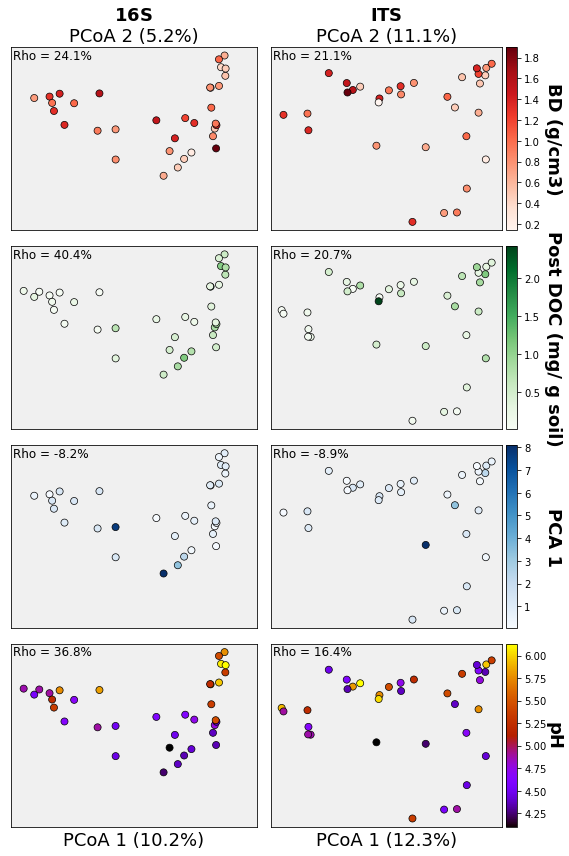

In [18]:
### BRAY-CURTIS

figsize = (8,12) # same ratio, bigger text
fig, ((ax11, ax12),(ax21, ax22),(ax31, ax32),(ax41, ax42)) = plt.subplots(4, 2, figsize=figsize, sharex=True, sharey=True)

color1 = 'BD (g/cm3)'
cmap1 = pl.cm.Reds
color2 = 'Post DOC (mg/ g soil)'
cmap2 = pl.cm.Greens
color3 = 'PCA 1'
cmap3 = pl.cm.Blues
color4 = 'pH'
cmap4 = pl.cm.gnuplot
####### 16s
ord_results = pcoa_bc_16s
column = color1
df = plotting_df_16s[[column,'PCA1_bc_16s','PCA2_bc_16s']].dropna(axis=0)
dm = dm_df_bc_16s.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_16s']
ys = df['PCA2_bc_16s']
####### Axis 1,1
ax11.set_facecolor('#f0f0f0')
# Choose colormap
color_map = cmap1

anno_text = ''

plot = ax11.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax11.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
ax11.set_xticklabels([])
ax11.set_yticklabels([])
ax11.margins(0.05)
ax11.grid(False)
plt.tight_layout()
# print(bioenv(dm, df[[column]])['correlation'][0]*100)

####### Axis 2,1
ax21.set_facecolor('#f0f0f0')
ord_results = pcoa_bc_16s
column = color2
df = plotting_df_16s[[column,'PCA1_bc_16s','PCA2_bc_16s']].dropna(axis=0)
dm = dm_df_bc_16s.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_16s']
ys = df['PCA2_bc_16s']
# Choose colormap
color_map = cmap2

anno_text = ''

plot = ax21.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, 
                      edgecolors = 'black', linewidth=0.69)

ax21.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
ax21.set_xticklabels([])
ax21.set_yticklabels([])
ax21.margins(0.05)
ax21.grid(False)
plt.tight_layout()

####### Axis 3,1
ax31.set_facecolor('#f0f0f0')
ord_results = pcoa_bc_16s
column = color3
df = plotting_df_16s[[column,'PCA1_bc_16s','PCA2_bc_16s']].dropna(axis=0)
dm = dm_df_bc_16s.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_16s']
ys = df['PCA2_bc_16s']
# Choose colormap
color_map = cmap3

anno_text = ''

plot = ax31.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax31.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100), 
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
ax31.set_xticklabels([])
ax31.set_yticklabels([])
ax31.margins(0.05)
ax31.grid(False)
plt.tight_layout()

####### Axis 3,1
ax41.set_facecolor('#f0f0f0')
ord_results = pcoa_bc_16s
column = color4
df = plotting_df_16s[[column,'PCA1_bc_16s','PCA2_bc_16s']].dropna(axis=0)
dm = dm_df_bc_16s.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_16s']
ys = df['PCA2_bc_16s']
# Choose colormap
color_map = cmap4

anno_text = ''

plot = ax41.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax41.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
ax41.set_xlabel('PCoA %d (%.1f%%)' % (1, ord_results.proportion_explained[0]*100), size=18)
ax41.set_xticklabels([])
ax41.set_yticklabels([])
ax41.margins(0.05)
ax41.grid(False)
plt.tight_layout()

####### ITS
ord_results = pcoa_bc_its
column = color1
df = plotting_df_its[[column,'PCA1_bc_its','PCA2_bc_its']].dropna(axis=0)
dm = dm_df_bc_its.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_its']
ys = df['PCA2_bc_its']
####### Axis 1,2
ax12.set_facecolor('#f0f0f0')
column = color1
# Choose colormap
color_map = cmap1

anno_text = ''

plot = ax12.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax12.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.margins(0.05)
ax12.grid(False)
divider = make_axes_locatable(ax12)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(plot, cax=cax)
plt.tight_layout()

####### Axis 2,2
ax22.set_facecolor('#f0f0f0')
column = color2
df = plotting_df_its[[column,'PCA1_bc_its','PCA2_bc_its']].dropna(axis=0)
dm = dm_df_bc_its.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_its']
ys = df['PCA2_bc_its']
# Choose colormap
color_map = cmap2

anno_text = ''

plot = ax22.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, 
                      edgecolors = 'black', linewidth=0.69)

ax22.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

ax22.set_xticklabels([])
ax22.set_yticklabels([])
ax22.margins(0.05)
ax22.grid(False)
divider = make_axes_locatable(ax22)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(plot, cax=cax)
plt.tight_layout()

####### Axis 3,2
ax32.set_facecolor('#f0f0f0')
column = color3
df = plotting_df_its[[column,'PCA1_bc_its','PCA2_bc_its']].dropna(axis=0)
dm = dm_df_bc_its.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_its']
ys = df['PCA2_bc_its']
# Choose colormap
color_map = cmap3

anno_text = ''

plot = ax32.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax32.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100), 
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')

ax32.set_xticklabels([])
ax32.set_yticklabels([])
ax32.margins(0.05)
ax32.grid(False)
divider = make_axes_locatable(ax32)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(plot, cax=cax)
plt.tight_layout()

####### Axis 4,2
ax42.set_facecolor('#f0f0f0')
column = color4
df = plotting_df_its[[column,'PCA1_bc_its','PCA2_bc_its']].dropna(axis=0)
dm = dm_df_bc_its.filter(df.index)
ids = df.index.values
xs = df['PCA1_bc_its']
ys = df['PCA2_bc_its']
# Choose colormap
# Choose colormap
color_map = cmap4

anno_text = ''

plot = ax42.scatter(xs, ys, c=np.abs(df[column]), cmap=color_map, s = 50, edgecolors = 'black', linewidth=0.69)

ax42.annotate(anno_text + 'Rho = %.1f%%' % (bioenv(dm, df[[column]])['correlation'][0]*100),
              size=12,xy=(0.01,0.99), xycoords='axes fraction',horizontalalignment='left', verticalalignment='top')
ax42.set_xlabel('PCoA %d (%.1f%%)' % (1, ord_results.proportion_explained[0]*100), size=18)
ax42.set_xticklabels([])
ax42.set_yticklabels([])
ax42.margins(0.05)
ax42.grid(False)
divider = make_axes_locatable(ax42)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(plot, cax=cax)
plt.tight_layout()

###### Saving
plt.subplots_adjust(hspace = 0.1, wspace = 0.02)
for ax in [ax11, ax12, ax21, ax22, ax31, ax32, ax41, ax42]:
    ax.set_xticks([])
    ax.set_yticks([])
cols = ['16S','ITS']
scores = ['PCoA %d (%.1f%%)' % (2, pcoa_bc_16s.proportion_explained[1]*100), 'PCoA %d (%.1f%%)' % (2, pcoa_bc_its.proportion_explained[1]*100)]
for ax, col, score in zip([ax11,ax12], cols, scores):
    ax.set_title(r'$\bf{' + col + '}$' + '\n' + score, size=18)
rows = [color1, color2, color3, color4]
for ax, row in zip([ax12,ax22,ax32,ax42], rows):
    current_label = ax.xaxis.get_label()
    ax.set_ylabel(row, size=18,rotation=-90, weight = 'bold', labelpad = 60)
    ax.yaxis.set_label_position('right')
plt.tight_layout()

filename = 'all_pcoas_paired_final.jpg'
plt.savefig(filename, dpi = 300, format = 'jpg')

In [19]:
# Beta diversity comparisons

In [20]:
# Redundancy

In [21]:
treatment_perm_16s = permanova(DistanceMatrix(dm_df_bc_16s), plotting_df_16s['Landform'].values, permutations=999)
treatment_perm_16s

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  2
test statistic              3.03473
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [22]:
treatment_perm_16s_depth = permanova(DistanceMatrix(dm_df_bc_16s), plotting_df_16s['Depth_PG_M'].values, permutations=999)
treatment_perm_16s_depth

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  4
test statistic              2.20302
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [23]:
treatment_perm_16s_year = permanova(DistanceMatrix(dm_df_bc_16s), plotting_df_16s['year_landform'].values, permutations=999)
treatment_perm_16s_year

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  3
test statistic              2.12747
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [24]:
treatment_perm_its = permanova(DistanceMatrix(dm_df_bc_its), plotting_df_its['Landform'].values, permutations=999)
treatment_perm_its

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  2
test statistic              3.07027
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [25]:
treatment_perm_its_depth = permanova(DistanceMatrix(dm_df_bc_its), plotting_df_its['Depth_PG_M'].values, permutations=999)
treatment_perm_its_depth

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  4
test statistic              2.05465
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [26]:
treatment_perm_its_year = permanova(DistanceMatrix(dm_df_bc_its), plotting_df_its['year_landform'].values, permutations=999)
treatment_perm_its_year

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      35
number of groups                  3
test statistic              2.45089
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

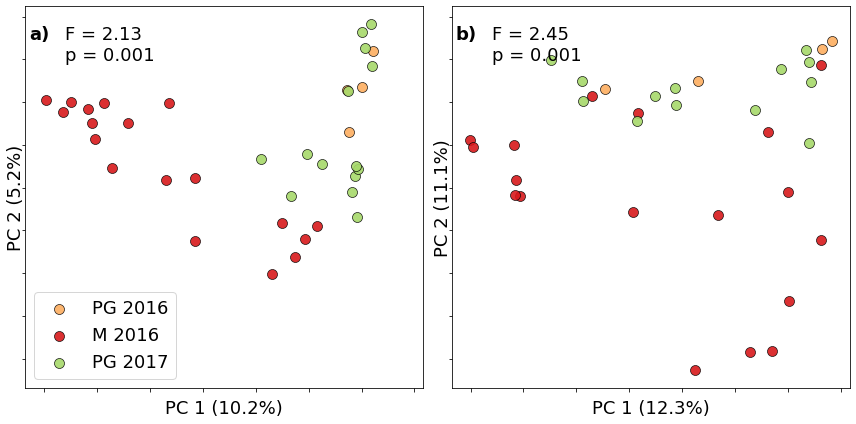

In [27]:
figsize = (12,6)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

colors = ['#fdae61','#d7191c','#a6d96a','#1a9641']
labels = ['Patterned Ground', 'Meadow']
treatments = ['2016_PG','2016_M','2017_PG']

PG_6 = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['year_landform'] == treatments[0]], 
            color = colors[0], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
M_6 = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['year_landform'] == treatments[1]], 
            color = colors[1], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
PG_7 = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['year_landform'] == treatments[2]], 
                color = colors[2], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax11.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_16s.proportion_explained[0]*100), size=18)
ax11.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_16s.proportion_explained[1]*100), size=18)
ax11.yaxis.set_label_coords(0,0.5)
ax11.annotate('F = ' + str(round(treatment_perm_16s_year[4], 2)) + '\n' + 'p = ' + str(treatment_perm_16s_year[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax11.annotate('a)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax11.set_xticklabels([])
ax11.set_yticklabels([])
ax11.legend((PG_6, M_6, PG_7),
           ('PG 2016', 'M 2016','PG 2017'),
           scatterpoints=1, loc='lower left', fontsize = 18)
ax11.grid(False)

for i in range(3):
    ax12.scatter('PCA1_bc_its', 'PCA2_bc_its', data = plotting_df_its[plotting_df_its['year_landform'] == treatments[i]], 
                color = colors[i], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax12.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_its.proportion_explained[0]*100), size=18)
ax12.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_its.proportion_explained[1]*100), size=18)
ax12.yaxis.set_label_coords(0,0.5)
ax12.annotate('F = ' + str(round(treatment_perm_its_year[4], 2)) + '\n' + 'p = ' + str(treatment_perm_its_year[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax12.annotate('b)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.grid(False)

plt.tight_layout()
plt.savefig('categorical_pcoa_year.png', dpi = 300, format = 'png')

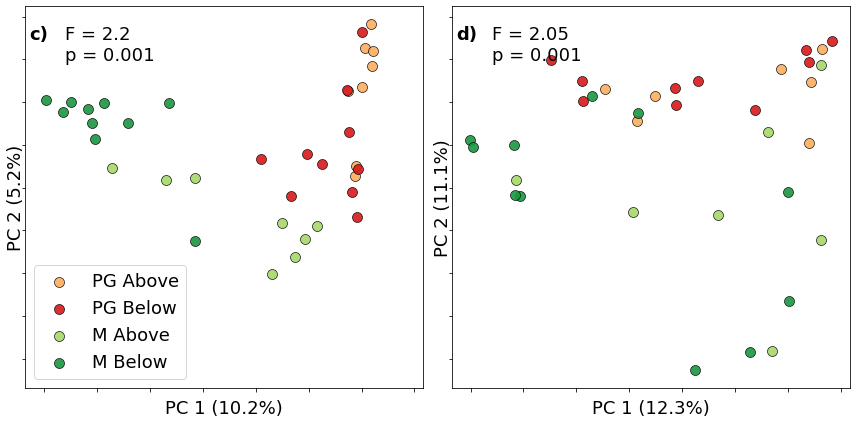

In [28]:
figsize = (12,6)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

colors = ['#fdae61','#d7191c','#a6d96a','#1a9641']
labels = ['Patterned Ground', 'Meadow']
treatments = ['PGA','PGB','MA','MB']

PGa = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Depth_PG_M'] == treatments[0]], 
            color = colors[0], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
PGb = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Depth_PG_M'] == treatments[1]], 
            color = colors[1], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
Ma = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Depth_PG_M'] == treatments[2]], 
                color = colors[2], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
Mb = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Depth_PG_M'] == treatments[3]], 
                color = colors[3], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax11.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_16s.proportion_explained[0]*100), size=18)
ax11.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_16s.proportion_explained[1]*100), size=18)
ax11.yaxis.set_label_coords(0,0.5)
ax11.annotate('F = ' + str(round(treatment_perm_16s_depth[4], 2)) + '\n' + 'p = ' + str(treatment_perm_16s_depth[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax11.annotate('c)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax11.set_xticklabels([])
ax11.set_yticklabels([])
ax11.legend((PGa, PGb, Ma, Mb),
           ('PG Above','PG Below', 'M Above','M Below'),
           scatterpoints=1, loc='lower left', fontsize = 18)
ax11.grid(False)

for i in range(4):
    ax12.scatter('PCA1_bc_its', 'PCA2_bc_its', data = plotting_df_its[plotting_df_its['Depth_PG_M'] == treatments[i]], 
                color = colors[i], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax12.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_its.proportion_explained[0]*100), size=18)
ax12.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_its.proportion_explained[1]*100), size=18)
ax12.yaxis.set_label_coords(0,0.5)
ax12.annotate('F = ' + str(round(treatment_perm_its_depth[4], 2)) + '\n' + 'p = ' + str(treatment_perm_its_depth[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax12.annotate('d)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.grid(False)

plt.tight_layout()
plt.savefig('categorical_pcoa_depth.png', dpi = 300, format = 'png')

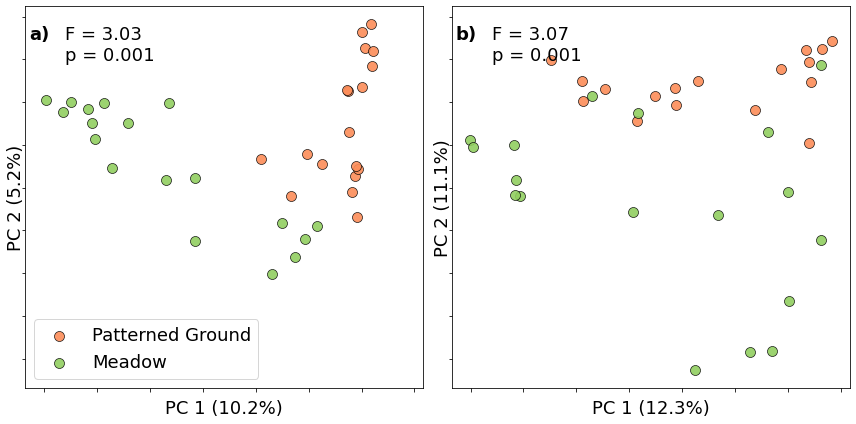

In [29]:
figsize = (12,6)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)

colors = ['#fc8d59','#91cf60']
labels = ['Patterned Ground', 'Meadow']
treatment = ['PG','M']

PG = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Landform'] == treatment[0]], 
                color = colors[0], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)
M = ax11.scatter('PCA1_bc_16s', 'PCA2_bc_16s', data = plotting_df_16s[plotting_df_16s['Landform'] == treatment[1]], 
                color = colors[1], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax11.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_16s.proportion_explained[0]*100), size=18)
ax11.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_16s.proportion_explained[1]*100), size=18)
ax11.yaxis.set_label_coords(0,0.5)
ax11.annotate('F = ' + str(round(treatment_perm_16s[4], 2)) + '\n' + 'p = ' + str(treatment_perm_16s[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax11.annotate('a)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax11.set_xticklabels([])
ax11.set_yticklabels([])
ax11.legend((PG, M),
           ('Patterned Ground', 'Meadow'),
           scatterpoints=1, loc='lower left', fontsize = 18)
ax11.grid(False)

for i in range(2):
    ax12.scatter('PCA1_bc_its', 'PCA2_bc_its', data = plotting_df_its[plotting_df_its['Landform'] == treatment[i]], 
                color = colors[i], alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

ax12.set_xlabel('PC %d (%.1f%%)' % (1, pcoa_bc_its.proportion_explained[0]*100), size=18)
ax12.set_ylabel('PC %d (%.1f%%)' % (2, pcoa_bc_its.proportion_explained[1]*100), size=18)
ax12.yaxis.set_label_coords(0,0.5)
ax12.annotate('F = ' + str(round(treatment_perm_its[4], 2)) + '\n' + 'p = ' + str(treatment_perm_its[5]),
            xy=(0.1, 0.95), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top', size=18)

ax12.annotate('b)',xy=(0.01, 0.95), xycoords='axes fraction',
                horizontalalignment='left', verticalalignment='top', size=18, fontweight = 'bold')
ax12.set_xticklabels([])
ax12.set_yticklabels([])
ax12.grid(False)

plt.tight_layout()
plt.savefig('categorical_pcoa.png', dpi = 300, format = 'png')

In [30]:
otu_16S_df_paired = pd.read_csv('../Bioinformatics/16S/core-metrics-results-paired/otus/alpha-diversity.tsv', sep = '\t', index_col = 0)
otu_ITS_df_paired = pd.read_csv('../Bioinformatics/ITS/core-metrics-results-paired/otus/alpha-diversity.tsv', sep = '\t', index_col = 0)
alpha_div_16S = pd.DataFrame()
alpha_div_ITS = pd.DataFrame()
alpha_div_16S['OTUs'] = otu_16S_df_paired['observed_features']
alpha_div_16S['Community'] = '16S'
alpha_div_ITS['OTUs'] = otu_ITS_df_paired['observed_features']
alpha_div_ITS['Community'] = 'ITS'
alpha_div_16S = alpha_div_16S.merge(map_df[['Landform', 'Depth(cm)']], left_index=True, right_index=True)
alpha_div_ITS = alpha_div_ITS.merge(map_df[['Landform', 'Depth(cm)']], left_index=True, right_index=True)
alpha_div = pd.concat([alpha_div_16S, alpha_div_ITS])

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Community', ylabel='OTUs'>

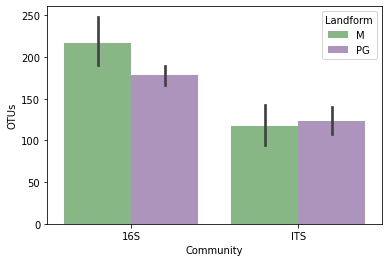

In [31]:
sns.barplot('Community', 'OTUs', hue = 'Landform', data = alpha_div, palette = ['#7fbf7b','#af8dc3'])

In [32]:
map_df.head()

,LinkerPrimerSequence,BarcodeSequence,Landform,Pit,Landform.1,ID,Depth(cm),Depth_category,Depth_PG_M,x,...,CBH_umol/cm^2 SF C,PHOS_umol/cm^2 SF C,NAG_umol/cm^2 SF C,BX_umol/cm^2 SF C,AG_umol/cm^2 SF C,LAP_umol/cm^2 SF C,C (kg/m^2),org C (kg/m^2),PCA 1,PCA 2
M-SS2-11,GTGCCAGCMGCCGCGGTAA,ACTACGTGTGGT,M,M1,M,5,11,A,MA,-106.3302,...,NaN,NaN,NaN,NaN,NaN,NaN,2.294039,12.754855,NaN,NaN
M-SS2-130,GTGCCAGCMGCCGCGGTAZA,CCTCTCGTGATC,M,M1,M,8,130,B,MB,-106.3302,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.084524,0.145382,-1.291782,-0.041531
M-SS2-160,GTGCCAGCMGCCGCGGTAA,CATATCGCAGTT,M,M1,M,9,160,B,MB,-106.3302,...,NaN,NaN,NaN,NaN,NaN,NaN,0.197268,0.274203,NaN,NaN
M-SS2-30,GTGCCAGCMGCCGCGGTAA,AGCTGACTAGTC,M,M1,M,6,30,A,MA,-106.3302,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.025437,1.261287,-1.078399,-0.064304
M-SS2-80,GTGCCAGCMGCCGCGGTAA,CCGACTGAGATG,M,M1,M,7,80,B,MB,-106.3302,...,189.976736,0.0,0.0,0.0,0.0,0.0,1.201094,1.405281,0.087181,3.286058


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PCA1_bc_16s', ylabel='% Sand'>

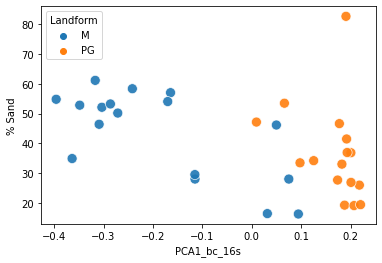

In [33]:
sns.scatterplot('PCA1_bc_16s', '% Sand', hue = 'Landform', data = plotting_df_16s, 
                alpha = 0.9, edgecolors = 'black', linewidth = 0.69, s = 100)

In [34]:
map_df.columns.values

array(['LinkerPrimerSequence', 'BarcodeSequence', 'Landform', 'Pit',
       'Landform.1', 'ID', 'Depth(cm)', 'Depth_category', 'Depth_PG_M',
       'x', 'y', 'date', 'year', 'year_landform', 'precip_1month',
       'precip_2month', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'Missing16S', 'MissingITS', 'BD (g/cm3)', '% total C',
       '% Minerals', '% OM', '% Org C', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay', 'BG_nmol/g/hr',
       'CBH_nmol/g/hr', 'PHOS_nmol/g/hr', 'NAG_nmol/g/hr', 'BX_nmol/g/hr',
       'AG_nmol/g/hr', 'LAP_nmol/g/hr', 'BG_umol/cm^2 stone-free',
       'CBH_umol/cm^2 stone-free', 'PHOS_umol/cm^2 stone-free',
       'NAG_umol/cm^2 stone-free', 'BX_umol/cm^2 stone-free',
       'AG_umol/cm^2 stone-free', 'LAP_umol/cm^2 stone-free',
 

In [40]:
def summarize_bioenv(columns, dataframes, dataframe_names):
    bioenv_df = pd.DataFrame(columns=['Landform','Dataframe','Column','Result'])
    matrices = dataframes
    matrix_names = dataframe_names
    for i in range(len(dataframes)):
        for j in ['PG','M']:
            for column in columns:
#                 print(i, j, column)
                env_data = map_df[map_df.index.isin(matrices[i].ids)][['Landform',column]].dropna()
                env_data = env_data[env_data['Landform'] == j]
                bio_data = matrices[i].filter(env_data.index)
                tmp_df = pd.DataFrame([[j,matrix_names[i],column,bioenv(bio_data, env_data[[column]])['correlation'][0]*100]],
                                     columns=['Landform','Dataframe','Column','Result'])
#                 print(bioenv(bio_data, env_data[[column]])['correlation'][0]*100)
#                 print(tmp_df)
                bioenv_df = bioenv_df.append(tmp_df,ignore_index=True)
    return bioenv_df

<AxesSubplot:xlabel='Dataframe', ylabel='Result'>

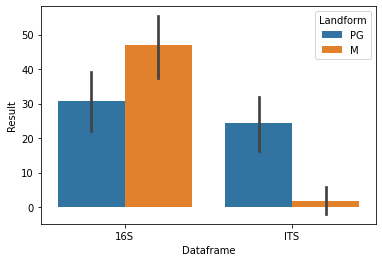

In [44]:
# env and enzymes, all vs above 30cm
columns = ['Depth(cm)', 'pH', 'Co2-C (ug/m^2) stone-free',
       'PMC (ug/g soil)', 'Total C (mg/g soil)', 'Total N (mg/g soil)',
       'BD (g/cm3)', '% total C', '% OM', 'org c (g/kg)', '% C', '% N',
       'C:N', 'Post DOC (mg/ g soil)', 'Post DON (mg/ g soil)',
       'C (g/m^2)', 'N (g/m^2)', 'D21 NH4 + NO3 avg/sample',
       'NO3- (ug/g soil)', '% Sand', '% Silt', '% Clay',
          'BG_umol/cm^2 SF C', 'CBH_umol/cm^2 SF C', 'PHOS_umol/cm^2 SF C',
       'NAG_umol/cm^2 SF C', 'BX_umol/cm^2 SF C', 'AG_umol/cm^2 SF C']
bioenv_df = summarize_bioenv(columns,[dm_df_bc_16s, dm_df_bc_its],
                            ['16S', 'ITS','16SA','ITSA', '16SB', 'ITSB'])
sns.barplot(y = 'Result', x = 'Dataframe', hue = 'Landform', data = bioenv_df)#, hue_order = ['16S','16S_30','ITS','ITS_30'])

In [46]:
bioenv_df.to_csv('../Data/bioenvs_table_M_PG.csv')

[Text(0.5, 0, 'common xlabel'), Text(0, 0.5, 'Average spearman correlation')]

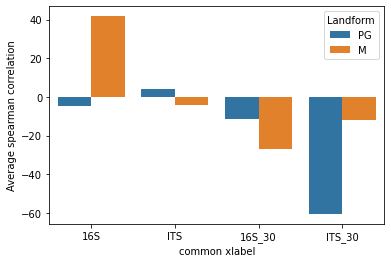

In [39]:
# Just enzymes, all vs above 30cm
# columns = ['BG_umol/cm^2 SF C','CBH_umol/cm^2 SF C','BX_umol/cm^2 SF C',
#        'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C','AG_umol/cm^2 SF C']
columns = ['PCA 1']
bioenv_df = summarize_bioenv(columns, [dm_df_bc_16s, dm_df_bc_its, dm_df_bc_16s_30, dm_df_bc_its_30],
                            ['16S', 'ITS','16S_30','ITS_30'])
ax = sns.barplot(y = 'Result', x = 'Dataframe', hue = 'Landform', data = bioenv_df)#, hue_order = ['16S','16S_30','ITS','ITS_30'])
ax.set(xlabel='common xlabel', ylabel='Average spearman correlation')

<AxesSubplot:xlabel='Dataframe', ylabel='Result'>

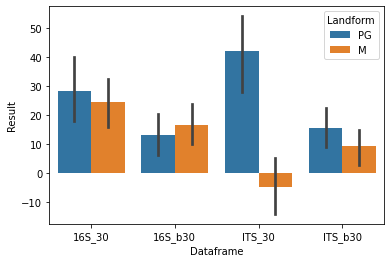

In [40]:
#Just enzymes, below vs above 30cm - (crashes on Meadow 16s_b30, 'AG_nmol/g/hr' and 'LAP_nmol/g/hr')
columns = ['Depth(cm)', 'pH',
           'BD (g/cm3)', '% total C', '% Minerals', '% OM', '% Org C',
           'org c (g/kg)', '% C', '% N', 'C:N', 'Post DOC (mg/ g soil)',
           'Post DON (mg/ g soil)', 'C (g/m^2)', 'N (g/m^2)',
           'D21 NH4 + NO3 avg/sample', 'NO3- (ug/g soil)', '% Sand', '% Silt',
           '% Clay','PCA 1','PCA 2','C (kg/m^2)', 'org C (kg/m^2)','Co2-C (ug/m^2) stone-free', 'PMC (ug/g soil)']
bioenv_df = summarize_bioenv(columns, [dm_df_bc_16s_b30, dm_df_bc_its_b30, dm_df_bc_16s_30, dm_df_bc_its_30],
                            ['16S_b30', 'ITS_b30','16S_30','ITS_30'])
sns.barplot(y = 'Result', x = 'Dataframe', hue = 'Landform', data = bioenv_df, order = ['16S_30','16S_b30','ITS_30','ITS_b30'])

<AxesSubplot:xlabel='Dataframe', ylabel='Result'>

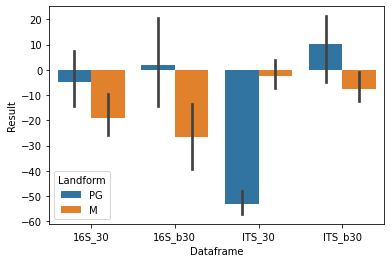

In [41]:
#Just enzymes, below vs above 30cm - (crashes on Meadow 16s_b30, 'AG_nmol/g/hr' and 'LAP_nmol/g/hr')
columns = ['BG_umol/cm^2 SF C','CBH_umol/cm^2 SF C','BX_umol/cm^2 SF C',
       'PHOS_umol/cm^2 SF C', 'NAG_umol/cm^2 SF C']
bioenv_df = summarize_bioenv(columns, [dm_df_bc_16s_b30, dm_df_bc_its_b30, dm_df_bc_16s_30, dm_df_bc_its_30],
                            ['16S_b30', 'ITS_b30','16S_30','ITS_30'])
sns.barplot(y = 'Result', x = 'Dataframe', hue = 'Landform', data = bioenv_df, order = ['16S_30','16S_b30','ITS_30','ITS_b30'])

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Landform', ylabel='BG_nmol/g/hr'>

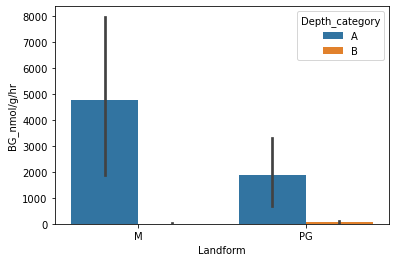

In [42]:
sns.barplot('Landform', 'BG_nmol/g/hr', hue = 'Depth_category', data = map_df)